Put the data excel file in the same directory of the code

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import metrics
import seaborn as sns
import scipy.stats as st
from matplotlib import colors

In [2]:
if not os.path.exists('output_figures'):
    os.mkdir('output_figures')

In [3]:
def parkes_error_zone_detailed(act, pred):
    """返回每个点所处的区域,输入的单位必须为mg/dl
    0:   A
    1,2: B
    3,4: C
    5,6: D
    7:   E
    """
    # print(act,pred)
    def above_line(x_1, y_1, x_2, y_2, strict=False):
        if x_1 == x_2:
            return False
        y_line = ((y_1 - y_2) * act + y_2 * x_1 - y_1 * x_2) / (x_1 - x_2)
        return pred > y_line if strict else pred >= y_line

    def below_line(x_1, y_1, x_2, y_2, strict=False):
        return not above_line(x_1, y_1, x_2, y_2, not strict)

    def parkes_type_1(act, pred):
        # Zone E
        if above_line(0, 150, 35, 155) and above_line(35, 155, 50, 550):
            return 7
        # Zone D - left upper
        if (pred > 100 and above_line(25, 100, 50, 125) and
                above_line(50, 125, 80, 215) and above_line(80, 215, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 550, 150)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 50, 80) and
                above_line(50, 80, 70, 110) and above_line(70, 110, 260, 550)):
            return 4
        # Zone C - right lower
        if (act > 120 and below_line(120, 30, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 140, 170) and
                above_line(140, 170, 280, 380) and (act < 280 or above_line(280, 380, 430, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 170, 145) and
                below_line(170, 145, 385, 300) and (act < 385 or below_line(385, 300, 550, 450))):
            return 1
        # Zone A
        return 0
    return parkes_type_1(act, pred)
parkes_error_zone_detailed = np.vectorize(parkes_error_zone_detailed)

In [4]:
data = pd.read_excel('Dataset_muSORS.xlsx', sheet_name='Fig.3c-f, Extended Data Fig.6-8')
data = data.to_numpy()

In [5]:
def num2str_array(array):
    new_arr = []
    for x in array:
        try:
            new_arr.append(float(x))
        except:
            new_arr.append(np.nan)
    return np.array(new_arr)

In [6]:
subject = data[2:, 0]
sampling_point = data[2:, 1]
VPG = data[2:, 2]
y_true_1 = num2str_array(data[2:, 3])
y_pred_1 = num2str_array(data[2:, 4])
y_true_2 = num2str_array(data[2:, 5])
y_pred_2 = num2str_array(data[2:, 6])
subject_number = np.array([int(x[1:]) if not pd.isnull(x) else np.nan for x in subject])
subject_type = np.array([x[0] if not pd.isnull(x) else np.nan for x in subject])

In [7]:
ref_values_cross = np.concatenate((y_true_1[~np.isnan(y_true_1)], y_true_2[~np.isnan(y_true_2)]))
pred_values_cross = np.concatenate((y_pred_1[~np.isnan(y_pred_1)], y_pred_2[~np.isnan(y_pred_2)]))

In [8]:
# mmol/L to mg/dL
if np.nanmax(ref_values_cross) < 60:
    ref_values_cross = ref_values_cross*18
    pred_values_cross = pred_values_cross*18

In [9]:
sns.set_theme()
sns.set_style('whitegrid')
title = "All"
show_mard = True
mode = "mmol/L"

In [10]:
def plot_colored_CEG(ref_values, pred_values, save_name, plot_range=35, mard=None):
    
    valid_idx = np.isnan(ref_values + pred_values) == 0
    ref_values = ref_values[valid_idx]
    pred_values = pred_values[valid_idx]
    
    if mard is None:
        mard = metrics.mard(ref_values, pred_values)
        
    res = parkes_error_zone_detailed(ref_values, pred_values)
    acc = np.zeros(9)
    acc_bin = np.bincount(res)
    acc[:len(acc_bin)] = acc_bin

    acc[1] = acc[1] + acc[2]
    acc[2] = acc[3] + acc[4]
    acc[3] = acc[5] + acc[6]
    acc[4] = acc[7] + acc[8]
    acc = acc[:5]
    acc_str = [str(np.round(x/np.sum(acc)*100,2)) + "%" for x in acc]
    
    #density
    x = ref_values
    y = pred_values
    xmin, xmax = 0, plot_range*18
    ymin, ymax = 0, plot_range*18

    xx, yy = np.mgrid[xmin:xmax:101j, ymin:ymax:101j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f0 = np.reshape(kernel(positions).T, xx.shape)
    f0 = f0*18**2 * len(x)
    
    plt.contourf(xx,yy,f0, cmap='turbo')
    h = plt.colorbar(label = 'Density')
    plt.xlabel("Reference Concentration (mmol/L)", fontsize=12, fontweight="bold")
    plt.ylabel("Predicted Concentration (mmol/L)", fontsize=12, fontweight="bold")
    plt.savefig('output_figures/density_'+save_name+'.pdf', bbox_inches='tight')
    
    f0_vec = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] <= xmax and y[i] <= ymax:
            x_ind = int(np.floor((x[i] - xmin)/(xmax - xmin)*100.))
            y_ind = int(np.floor((y[i] - ymin)/(ymax - ymin)*100.))
            f0_vec[i] = f0[y_ind, x_ind]
            
    # plot
    plt.figure(figsize=(5,5))
        
    density_thresh = h.boundaries
    #cmap = cm.get_cmap('turbo', len(density_thresh)-1)
    cmap = sns.color_palette('turbo', len(density_thresh)-1)
    for i in range(len(density_thresh)-1):
        #rgba = cmap(i)
        idx = np.where((f0_vec >= density_thresh[i])*(f0_vec < density_thresh[i+1]))[0]
        plt.scatter(ref_values[idx], pred_values[idx], marker='.', color=cmap[i], edgecolors=cmap[i], s=30)
        #matplotlib.colors.rgb2hex(rgba))

    if title=="" and (not show_mard):
        plt.title("Parkes Error Grid\n" + str(acc_str), fontsize=12, fontweight="bold")
    if title=="" and show_mard:
        plt.title("Parkes Error Grid\n" + f"MARD:{mard:.1%}  A+B:{(acc[0]+acc[1])/acc.sum():.1%} \
        A:{acc[0]/acc.sum():.1%}", fontsize=12, fontweight="bold")
    if title!="" and (not show_mard):
        plt.title(title+" Parkes Error Grid\n" + str(acc_str), fontsize=12, fontweight="bold", family='SimHei')
    if title!="" and show_mard:
        plt.title(title+" Parkes Error Grid\n" + f"MARD:{mard:.1%}  A+B:{(acc[0]+acc[1])/acc.sum():.1%} \
        A:{acc[0]/acc.sum():.1%}", fontsize=12, fontweight="bold")
    if mode=="mmol/L":
        plt.xlabel("Reference Concentration (mmol/L)", fontsize=12, fontweight="bold")
        plt.ylabel("Predicted Concentration (mmol/L)", fontsize=12, fontweight="bold")
    else:
        plt.xlabel("Reference Concentration (mg/dL)", fontsize=12, fontweight="bold")
        plt.ylabel("Predicted Concentration (mg/dL)", fontsize=12, fontweight="bold")
    if mode=="mmol/L":
        plt.xticks([0,90,180,270,360,450,540,630], ['0','5','10','15','20','25','30','35'], weight='bold')
        plt.yticks([0,90,180,270,360,450,540,630], ['0','5','10','15','20','25','30','35'], weight='bold')
    if mode=="mg/dL":
        plt.xticks([0, 100, 200, 300, 400, 500, 630], weight='bold')
        plt.yticks([0, 100, 200, 300, 400, 500, 630], weight='bold')
    plt.gca().set_facecolor('white')
    ax = plt.gca()
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.set_aspect('equal')
    #Plot zone lines
    plt.plot([0,630], [0,630], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([50, 50, 170, 385, 550, 630], [0, 30, 145, 300, 450, 522.7], '-', c='black')   # B bottom
    plt.plot([0, 30, 140, 280, 430, 500.6], [50, 50, 170, 380, 550, 630], '-', c='black')   # B up
    plt.plot([120, 120, 260, 550, 630], [0, 30, 130,250, 283.1], '-', c='black')   # C bottom
    plt.plot([0, 30, 50, 70, 260, 294.5], [60, 60, 80, 110,550,630], '-', c='black')   # C up
    plt.plot([250, 250, 550, 630], [0, 40,150, 179.3], '-', c='black')   # D buttom
    plt.plot([0,25,50,80,125,134.1], [100,100, 125,215, 550, 630], '-', c='black')   # D up
    plt.plot([0,35,50, 53], [150,155,550,630], '-', c='black')   # E up
    #Add zone titles
    if plot_range == 35:
        plt.text(400+80, 450+80, "A", fontsize=15)
        plt.text(450+80, 400+80, "A", fontsize=15)
        plt.text(450+80, 260+80, "B", fontsize=15)
        plt.text(280+60, 450+80, "B", fontsize=15)
        plt.text(140+40, 450+80, "C", fontsize=15)
        plt.text(450+80, 140+40, "C", fontsize=15)
        plt.text(60+20, 450+80, "D", fontsize=15)
        plt.text(450+80, 25+40, "D", fontsize=15)
        plt.text(20, 450+80, "E", fontsize=15)
    plt.xlim(0,plot_range*18)
    plt.ylim(0,plot_range*18)
    plt.tight_layout()
    plt.savefig('output_figures/colored_CEG_'+save_name+'.pdf')
    plt.show()

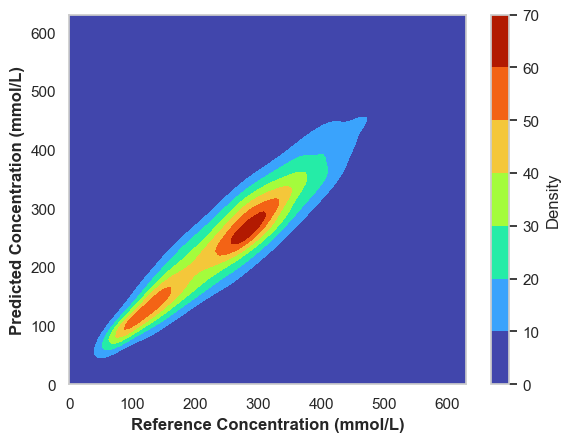

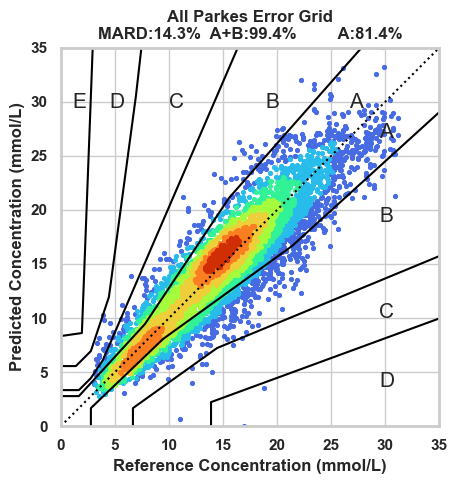

In [11]:
plot_colored_CEG(ref_values_cross, pred_values_cross, 'cross')

In [12]:
data_test = pd.read_excel('Dataset_muSORS.xlsx', sheet_name='Fig. 4b-d, Fig. 5')
data_test = data_test.to_numpy()

In [13]:
subject_test = data_test[2:, 0]
sampling_point_test = data_test[2:, 1]
VPG_test = data_test[2:, 2]
y_true_1_test = num2str_array(data_test[2:, 3])
y_pred_1_test = num2str_array(data_test[2:, 4])
y_true_2_test = num2str_array(data_test[2:, 5])
y_pred_2_test = num2str_array(data_test[2:, 6])
subject_number_test = np.array([int(x[1:]) if not pd.isnull(x) else np.nan for x in subject_test])
subject_type_test = np.array([x[0] if not pd.isnull(x) else np.nan for x in subject_test])

In [14]:
ref_values_test = np.concatenate((y_true_1_test[~np.isnan(y_true_1_test)], y_true_2_test[~np.isnan(y_true_2_test)]))
pred_values_test = np.concatenate((y_pred_1_test[~np.isnan(y_pred_1_test)], y_pred_2_test[~np.isnan(y_pred_2_test)]))

In [15]:
def plot_normal_CEG(ref_values, pred_values, save_name, plot_range=35, mard=None):
    
    valid_idx = np.isnan(ref_values + pred_values) == 0
    ref_values = ref_values[valid_idx]
    pred_values = pred_values[valid_idx]
    
    mard = metrics.mard(ref_values, pred_values)
        
    res = parkes_error_zone_detailed(ref_values, pred_values)
    acc = np.zeros(9)
    acc_bin = np.bincount(res)
    acc[:len(acc_bin)] = acc_bin

    acc[1] = acc[1] + acc[2]
    acc[2] = acc[3] + acc[4]
    acc[3] = acc[5] + acc[6]
    acc[4] = acc[7] + acc[8]
    acc = acc[:5]
    acc_str = [str(np.round(x/np.sum(acc)*100,2)) + "%" for x in acc]
            
    # plot
    plt.figure(figsize=(5,5))

    plt.scatter(ref_values, pred_values, marker='.', color=sns.color_palette()[0], edgecolors=sns.color_palette()[0], s=30)

    if title=="" and (not show_mard):
        plt.title("Parkes Error Grid\n" + str(acc_str), fontsize=12, fontweight="bold")
    if title=="" and show_mard:
        plt.title("Parkes Error Grid\n" + f"MARD:{mard:.1%}  A+B:{(acc[0]+acc[1])/acc.sum():.1%} \
        A:{acc[0]/acc.sum():.1%}", fontsize=12, fontweight="bold")
    if title!="" and (not show_mard):
        plt.title(title+" Parkes Error Grid\n" + str(acc_str), fontsize=12, fontweight="bold", family='SimHei')
    if title!="" and show_mard:
        plt.title(title+" Parkes Error Grid\n" + f"MARD:{mard:.1%}  A+B:{(acc[0]+acc[1])/acc.sum():.1%} \
        A:{acc[0]/acc.sum():.1%}", fontsize=12, fontweight="bold")
    if mode=="mmol/L":
        plt.xlabel("Reference Concentration (mmol/L)", fontsize=12, fontweight="bold")
        plt.ylabel("Predicted Concentration (mmol/L)", fontsize=12, fontweight="bold")
    else:
        plt.xlabel("Reference Concentration (mg/dL)", fontsize=12, fontweight="bold")
        plt.ylabel("Predicted Concentration (mg/dL)", fontsize=12, fontweight="bold")
    if mode=="mmol/L":
        plt.xticks([0,90,180,270,360,450,540,630], ['0','5','10','15','20','25','30','35'], weight='bold')
        plt.yticks([0,90,180,270,360,450,540,630], ['0','5','10','15','20','25','30','35'], weight='bold')
    if mode=="mg/dL":
        plt.xticks([0, 100, 200, 300, 400, 500, 630], weight='bold')
        plt.yticks([0, 100, 200, 300, 400, 500, 630], weight='bold')
    plt.gca().set_facecolor('white')
    ax = plt.gca()
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.set_aspect('equal')
    #Plot zone lines
    plt.plot([0,630], [0,630], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([50, 50, 170, 385, 550, 630], [0, 30, 145, 300, 450, 522.7], '-', c='black')   # B bottom
    plt.plot([0, 30, 140, 280, 430, 500.6], [50, 50, 170, 380, 550, 630], '-', c='black')   # B up
    plt.plot([120, 120, 260, 550, 630], [0, 30, 130,250, 283.1], '-', c='black')   # C bottom
    plt.plot([0, 30, 50, 70, 260, 294.5], [60, 60, 80, 110,550,630], '-', c='black')   # C up
    plt.plot([250, 250, 550, 630], [0, 40,150, 179.3], '-', c='black')   # D buttom
    plt.plot([0,25,50,80,125,134.1], [100,100, 125,215, 550, 630], '-', c='black')   # D up
    plt.plot([0,35,50, 53], [150,155,550,630], '-', c='black')   # E up
    #Add zone titles
    if plot_range == 35:
        plt.text(400+80, 450+80, "A", fontsize=15)
        plt.text(450+80, 400+80, "A", fontsize=15)
        plt.text(450+80, 260+80, "B", fontsize=15)
        plt.text(280+60, 450+80, "B", fontsize=15)
        plt.text(140+40, 450+80, "C", fontsize=15)
        plt.text(450+80, 140+40, "C", fontsize=15)
        plt.text(60+20, 450+80, "D", fontsize=15)
        plt.text(450+80, 25+40, "D", fontsize=15)
        plt.text(20, 450+80, "E", fontsize=15)
    plt.xlim(0,plot_range*18)
    plt.ylim(0,plot_range*18)
    plt.tight_layout()
    plt.savefig('output_figures/normal_CEG_'+save_name+'.pdf')
    plt.show()

In [16]:
# mmol/L to mg/dL
if np.nanmax(ref_values_test) < 60:
    ref_values_test = ref_values_test*18
    pred_values_test = pred_values_test*18

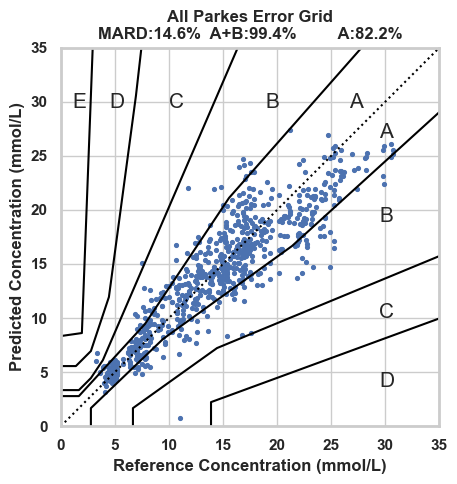

In [17]:
plot_normal_CEG(ref_values_test, pred_values_test, 'test')

In [18]:
data_train = pd.read_excel('Dataset_muSORS.xlsx', sheet_name='Extended Data Fig. 9')
data_train = data_train.to_numpy()

In [19]:
subject_train = data_train[2:, 0]
sampling_point_train = data_train[2:, 1]
VPG_train = data_train[2:, 2]
y_true_1_train = num2str_array(data_train[2:, 3])
y_pred_1_train = num2str_array(data_train[2:, 4])
y_true_2_train = num2str_array(data_train[2:, 5])
y_pred_2_train = num2str_array(data_train[2:, 6])
subject_number_train = np.array([int(x[1:]) if not pd.isnull(x) else np.nan for x in subject_train])
subject_type_train = np.array([x[0] if not pd.isnull(x) else np.nan for x in subject_train])

In [20]:
ref_values_train = np.concatenate((y_true_1_train[~np.isnan(y_true_1_train)], y_true_2_train[~np.isnan(y_true_2_train)]))
pred_values_train = np.concatenate((y_pred_1_train[~np.isnan(y_pred_1_train)], y_pred_2_train[~np.isnan(y_pred_2_train)]))

In [21]:
# mmol/L to mg/dL
if np.nanmax(ref_values_train) < 60:
    ref_values_train = ref_values_train*18
    pred_values_train = pred_values_train*18

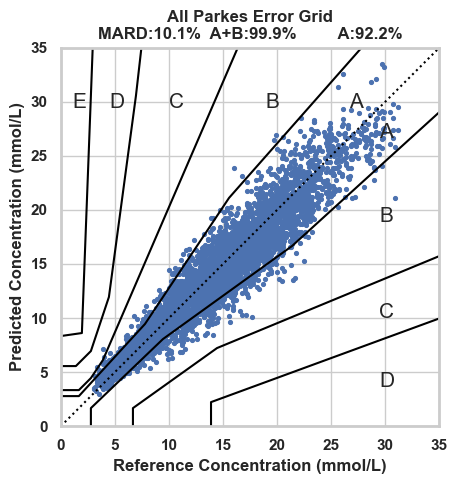

In [22]:
plot_normal_CEG(ref_values_train, pred_values_train, 'train')